# Problem 1: Convolution operations using NumPy

### Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import itertools

### Download the MNIST dataset and visualize samples

In [2]:
torch.manual_seed(0)
batch_size = 50
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 85635714.57it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65372743.56it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27491687.56it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13626987.67it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



You can check what kind of training images are in the MNIST dataset.

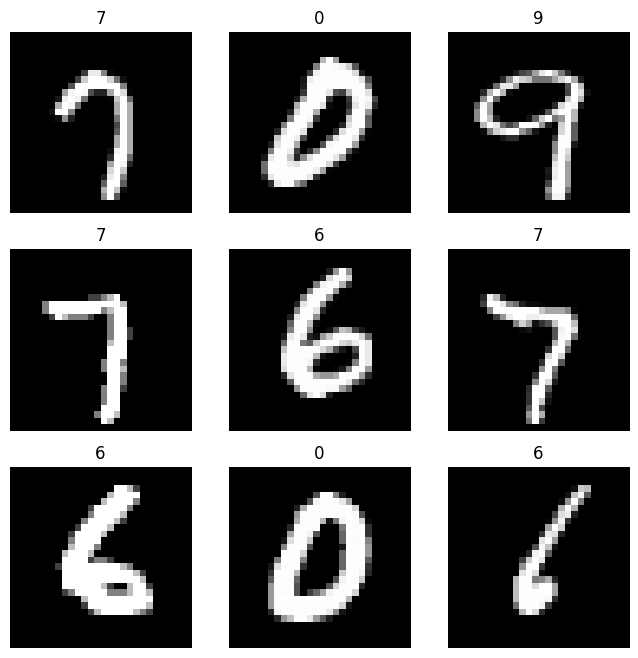

In [3]:
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We then define three filters used in convolution operations:

In [4]:
kernel_1 = [[1,0,0,0,0],
            [0,1,0,0,0],
            [0,0,1,0,0],
            [0,0,0,1,0],
            [0,0,0,0,1]]

kernel_2 = [[0,0,1,0,0],
            [0,0,1,0,0],
            [0,0,1,0,0],
            [0,0,1,0,0],
            [0,0,1,0,0]]

kernel_3 = [[0,0,0,0,1],
            [0,0,0,1,0],
            [0,0,1,0,0],
            [0,1,0,0,0],
            [1,0,0,0,0]]
filters = np.asarray([[kernel_1], [kernel_2], [kernel_3]])

We also define a visualization function for later uses.

In [5]:
def visualize_conv(img_0, img_filtered, img_pooled):
    """
    A 2D Convolution filter

    Parameters
    ---------- 
    img_0: matrix  
      an original image.
    img_filtered: 
      a list of images after applying convolution filters
    img_pooled:
      a list of images after applying convolution filters + avg pooling
    """

    figure = plt.figure(figsize=(8, 4))
    figure.add_subplot(2, 4, 1)
    plt.title("Original")
    plt.axis("off")
    plt.imshow(img_0.squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 2)
    plt.title("Filter 1")
    plt.axis("off")
    plt.imshow(img_filtered[0].squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 3)
    plt.title("Filter 2")
    plt.axis("off")
    plt.imshow(img_filtered[1].squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 4)
    plt.title("Filter 3")
    plt.axis("off")
    plt.imshow(img_filtered[2].squeeze(), cmap="gray")            

    figure.add_subplot(2, 4, 6)
    plt.title("Filter1 + Pooling")
    plt.axis("off")
    plt.imshow(img_pooled[0].squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 7)
    plt.title("Filter 2 + Pooling")
    plt.axis("off")
    plt.imshow(img_pooled[1].squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 8)
    plt.title("Filter 3 + Pooling")
    plt.axis("off")
    plt.imshow(img_pooled[2].squeeze(), cmap="gray")     

## Convolution + AvgPooling with Numpy 
In this part, we create convolution and pooling functions by only using NumPy.

In [6]:
def convolution(X, filters, stride_size=1, pad_size=0):
    """
    Applies a 2D convolution over an input signal

    Parameters
    ---------- 
    X: Numpy Array
      an input data of shape (c, h, w), where h and w is the height and width
      of the input image. Note that we use black-white images so the number of 
      channel c is 1.
  
    Returns
    ---------- 
    out:     
      an output data given X.
    """
    c, h, w = X.shape
    n_f, _, filter_h, filter_w = filters.shape

    out_h = (h + 2 * pad_size - filter_h) // stride_size + 1
    out_w = (w + 2 * pad_size - filter_w) // stride_size + 1

    # add padding to height and width.
    in_X = np.pad(X, [(0, 0), (pad_size, pad_size), (pad_size, pad_size)], 'constant')
    out  = np.zeros((n_f, out_h, out_w))

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    # Apply the convolution filters     

    for f in range(n_f):
      for i in range(0, out_h, stride_size):
        for j in range(0, out_w, stride_size):

          X_part = in_X[:, i:i+filter_h, j:j+filter_w]

          out[f,i,j] = np.sum(filters[f] * X_part)


    #############################################################################
    return out

def avg_pooling(X, pool_size=2, stride_size=2):
    """
    Applies a 2D average pooling over an input signal

    Parameters
    ---------- 
    X: Numpy Array  
      an input data of shape (c, h, w), where c, h, and w are the number of 
      channels, the height, and the width of the input image. 
  
    Returns
    ---------- 
    pool_out:     
      an output data given X.
    """
    c, h, w = X.shape

    #Preparing the output of the pooling operation.
    pool_out = np.zeros((c, 
                         np.uint16((h-pool_size)/stride_size)+1,
                         np.uint16((w-pool_size)/stride_size)+1,
                         ))
    
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################     
    # Apply average pooling
    
    for k in range(c): 
      for i in range(pool_out.shape[1]):
        for j in range(pool_out.shape[2]):
          
          X_part = X[k, i*stride_size:i*stride_size+pool_size, j*stride_size:j*stride_size+pool_size]

          pool_out[k, i, j] = np.mean(X_part)

     
    #############################################################################            
    return pool_out    

Visualize the filtering and pooling results for comparison.

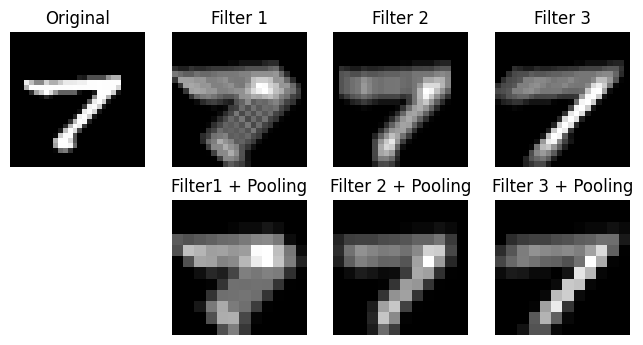

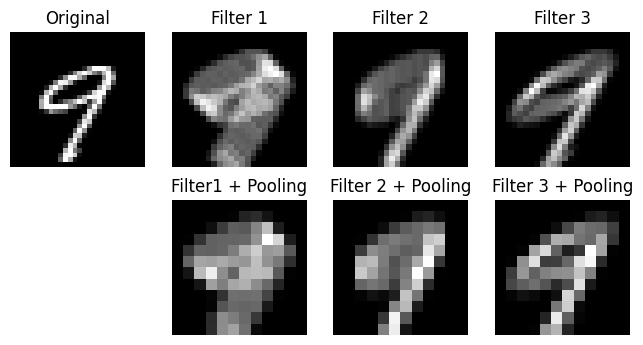

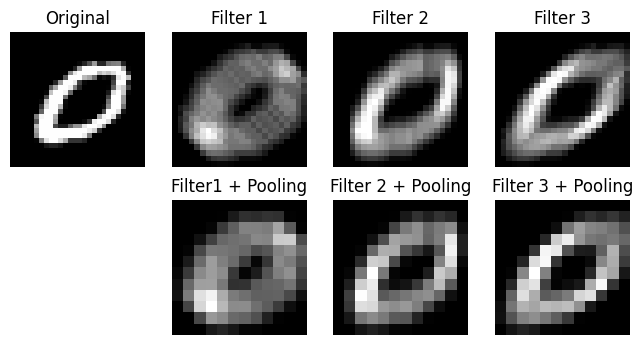

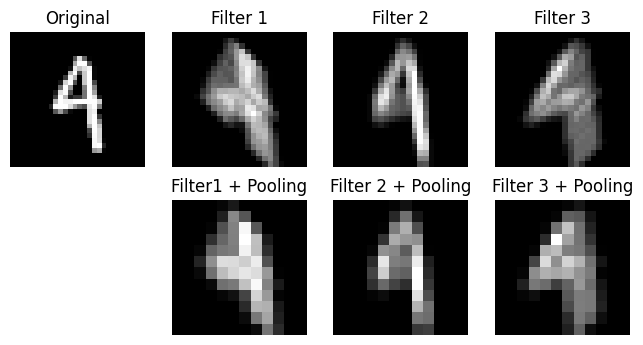

In [7]:
# fix the random seed
torch.manual_seed(6)
numpy_return = []

# visualize a random 5
for i in range(1, 5):
    sample_idx = torch.randint(len(train_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[sample_idx]

    out1 = convolution(img.numpy(), filters, stride_size=1, pad_size=0)
    out2 = avg_pooling(out1)

    visualize_conv(img, out1, out2)
    numpy_return.append([out1.copy(), out2.copy()]) # save the result
            

## Convolution + AvgPooling with PyTorch 
In this part, we create convolution and pooling functions by using PyTorch.

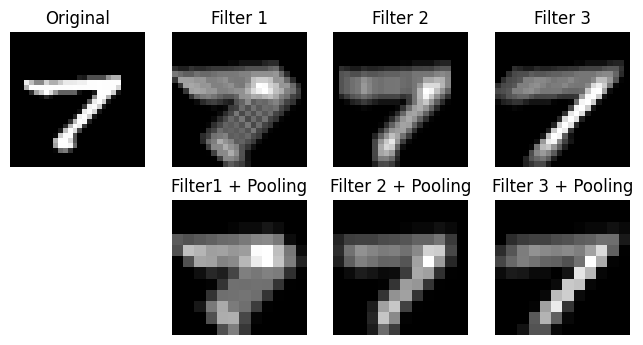

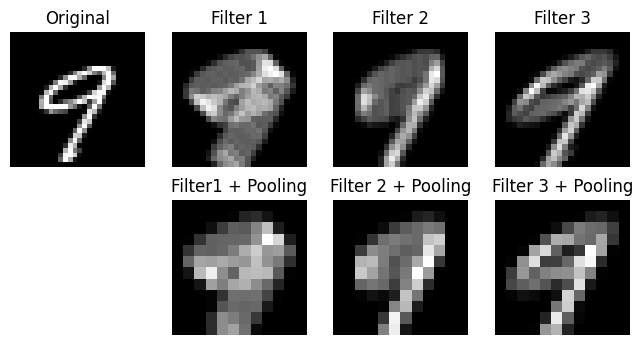

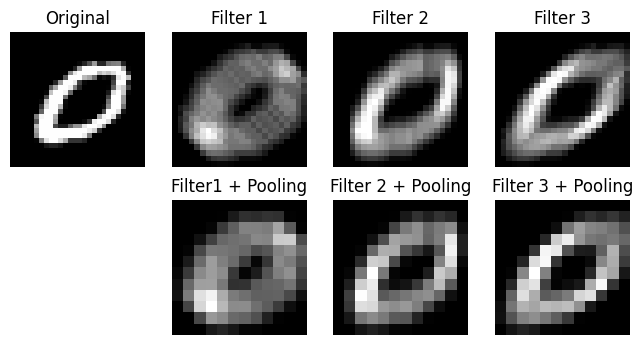

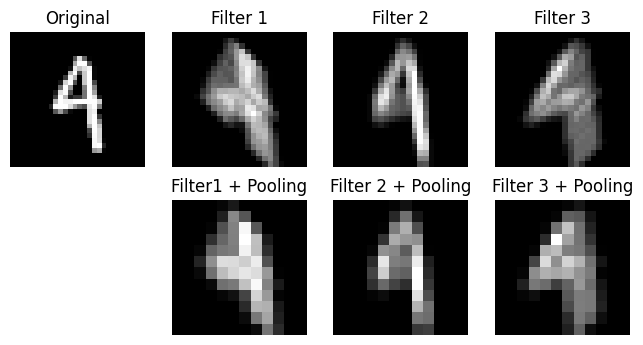

In [8]:

class CNN1(nn.Module):
  """
  A simple convolutional neural network (CNN):
    input - convolution - output
  """  
  def __init__(self):
    """initialize layers"""
    super(CNN1, self).__init__()

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    # Define a CNN layer with a single channel, 3 filters, and 5 kernel size.
    # You should diable using the bias.

    self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, bias=False)


    ############################################################################# 

    # Force to set the internal weight using the pre-defined kernels. 
    with torch.no_grad():
        self.conv.weight.data[0][0] = torch.tensor(kernel_1)
        self.conv.weight.data[1][0] = torch.tensor(kernel_2)
        self.conv.weight.data[2][0] = torch.tensor(kernel_3)        
        #self.conv.bias.data.zero_()

  def forward(self, x):
    """forward pass"""
    out = self.conv(x)
    return out

class CNN2(nn.Module):
  """
  A simple convolutional neural network (CNN):
    input - convolution - avg. pooling - output
  """    
  def __init__(self):
    """initialize layers"""
    super(CNN2, self).__init__()

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    # Define a CNN layer with a single channel, 3 filters, and 5 kernel size.
    # Connect a avg pooling with 2 kernel size. 
    # You should diable using the bias.
    
    self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, bias=False)
    self.pool = nn.AvgPool2d(kernel_size=2)
    
                                                       #
    ############################################################################# 

    # Force to set the internal weight using the pre-defined kernels. 
    with torch.no_grad():
        self.conv.weight.data[0][0] = torch.tensor(kernel_1)
        self.conv.weight.data[1][0] = torch.tensor(kernel_2)
        self.conv.weight.data[2][0] = torch.tensor(kernel_3)
        #self.conv.bias.data.zero_()

  def forward(self, x):
    """forward pass"""
    out = self.conv(x)
    out = self.pool(out)
    return out


filter_net         = CNN1()
filter_pooling_net = CNN2()

torch.manual_seed(6)
pytorch_return = []
for i in range(1, 5):
    sample_idx = torch.randint(len(train_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[sample_idx]
    x = img.unsqueeze(0)

    out1 = filter_net(x).detach().numpy()[0]
    out2 = filter_pooling_net(x).detach().numpy()[0]
 
    visualize_conv(x, out1, out2)
    pytorch_return.append([out1.copy(), out2.copy()])

To analyze two types of results, you can also compare the stored results, too. 

In [12]:
import numpy as np

mse_errors = []

for np_result, pt_result in zip(numpy_return, pytorch_return):
    np_out1, np_out2 = np_result
    pt_out1, pt_out2 = pt_result

    pt_out1 = pt_out1.squeeze()
    pt_out2 = pt_out2.squeeze()

    # Compute MSE convolution
    mse_conv = np.mean((np_out1 - pt_out1) ** 2)

    # Compute MSE for the average pooling
    mse_pool = np.mean((np_out2 - pt_out2) ** 2)

    mse_errors.append((mse_conv, mse_pool))

# Calculate the average MSE
avg_mse_conv = np.mean([mse_conv for mse_conv, _ in mse_errors])
avg_mse_pool = np.mean([mse_pool for _, mse_pool in mse_errors])


print("Average MSE:", (avg_mse_conv, avg_mse_pool))

Average MSE: (2.3516035169895075e-15, 3.4800341422477088e-15)
